In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import gridspec
from statannotations.Annotator import Annotator
import palettable as pal

from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

import sys
sys.path.append('../utility_code/')

import utils as utils
import general_utils as gen_utils

In [2]:
'''
colors
'''
import palettable as pal

clinC = pal.cartocolors.qualitative.Vivid_10.mpl_colors

mappings = {}

clinvars = ['Positive', 'No Response', 'MHC-Intact', 'Negative', 'MHC-LOH', 'Response', 'No Prior IO', 'Prior IO', 'History of smoking', 'No history of smoking']
mappings['clinical'] = {clinvars[q]:clinC[q] for q in range(len(clinvars))} | {'Not Assessed':{'facecolor': 'grey', 'alpha': 0.2}}
mappings['clinical']['Response'] = 'tab:green'

In [3]:
'''
grabbing cibersort results and merging with annotation data
'''

cib = pd.read_csv('../data/CIBERSORTx_Job16_Results.csv')

cib = cib.rename(columns={'Mixture':'analysis_id'})
# fixing mistake in annotations to ensure correct merging
cib.loc[cib['analysis_id'].str.match('M063-R-tiss'), 'analysis_id'] = 'M063-R-tiss-1'
# cib.loc[34, 'analysis_id'] = 'M063-R-tiss-1'

df_annot = pd.read_csv('../data/sample_annotations.tsv', index_col=0, sep='\t')

data = cib.merge(df_annot, on='analysis_id', how='left')

'''
creating a sum over relevant immune cell populations
'''

immune_cols = cib.columns.to_list()

for rem in ['P-value', 'Correlation', 'RMSE', 'Absolute score (sig.score)']:
    immune_cols.remove(rem)
    
# normalize absolute counts to relative counts
norm = cib[immune_cols].set_index('analysis_id')
norm = norm.div(norm.sum(axis=1), axis=0)
norm = norm.reset_index()

Cdf_raw = norm[immune_cols].melt(id_vars='analysis_id', var_name='cell_type', value_name='cell fraction')

# Cdf_raw = data[['analysis_id'] + immune_cols].melt(id_vars='analysis_id', var_name='cell_type', value_name='cell fraction')

'''
grouping cell types
'''

Cdf_raw['cell_type_coarse'] = Cdf_raw['cell_type'].astype(str)
Cdf_raw.loc[Cdf_raw['cell_type'].str.match('B|Plasma'),'cell_type_coarse'] = 'B-cell'
Cdf_raw.loc[Cdf_raw['cell_type'].str.match('T cells CD4'),'cell_type_coarse'] = 'T cells CD4'
Cdf_raw.loc[Cdf_raw['cell_type'].str.match('NK'),'cell_type_coarse'] = 'NK'
Cdf_raw.loc[Cdf_raw['cell_type'].str.match('Mono|Macro'),'cell_type_coarse'] = 'Monocytes'
Cdf_raw.loc[Cdf_raw['cell_type'].str.match('Dendritic'),'cell_type_coarse'] = 'DC'
Cdf_raw.loc[Cdf_raw['cell_type'].str.match('Mast'),'cell_type_coarse'] = 'Mast'

Cdf_coarse = Cdf_raw.groupby(['analysis_id','cell_type_coarse'])['cell fraction'].sum().reset_index()

#remove bad sample
Cdf_coarse = Cdf_coarse[Cdf_coarse['analysis_id']!='M008-NR-met']

# merge annotations
df = Cdf_coarse.merge(df_annot, on='analysis_id', how='left')

'''
subsetting to most recent pre-treatment samples
'''

ids = gen_utils.list_most_recent_pretreatment_samples(df)
df = df[df['analysis_id'].isin(ids)]

'''
subsetting to samples with response and HPV negative
'''
df = df[df['treatment_response'].isin(['Response', 'No Response'])]
df = df[df['hpv_status']=='Negative']

df.head(2)

,analysis_id,cell_type_coarse,cell fraction,Unnamed: 0,sample,participant,pdb_original_material_type,pdb_preservation_method,pdb_tumor_normal,sequence_no,...,best_response,treatment_response,hpv_status,smoking_status,preservation_method,tumor_state,collection_date_dfd,indicator,participant_analysis_id,P/M
63,M021-NR-tiss,B-cell,0.000468,139,SP-16-13653,MCC021,tissue,FFPE,tumor,MCC021,...,Progressive Disease,No Response,Negative,History of smoking,FFPE,NaN,22.0,tiss,M021-NR,Primary
64,M021-NR-tiss,DC,0.088263,139,SP-16-13653,MCC021,tissue,FFPE,tumor,MCC021,...,Progressive Disease,No Response,Negative,History of smoking,FFPE,NaN,22.0,tiss,M021-NR,Primary


In [4]:
'''
p testing
'''

# Only test cell types reaching above 5% in some sample
max_frac = df.groupby('cell_type_coarse')['cell fraction'].max()
ct_test = max_frac.index[max_frac>.1]
test_idx = df['cell_type_coarse'].isin(ct_test)

ind_tests = []

for cell_type in ct_test:
    ind_tests += [
        ((cell_type, 'Response'), (cell_type, 'No Response'))
    ]

ind_tests

[(('DC', 'Response'), ('DC', 'No Response')),
 (('Endothelial', 'Response'), ('Endothelial', 'No Response')),
 (('Fibroblast', 'Response'), ('Fibroblast', 'No Response')),
 (('Monocytes', 'Response'), ('Monocytes', 'No Response')),
 (('Myocyte', 'Response'), ('Myocyte', 'No Response')),
 (('T cells CD4', 'Response'), ('T cells CD4', 'No Response'))]

In [5]:
'''
p testing
'''

def ranksum_df(df,test_field,value_field,groupby):
    vals = df[test_field].unique()
    if len(vals) != 2:
        print("Error, there must be two unique categories to test")
        return()
    res = df.groupby(groupby).apply(lambda x: ranksums(x.loc[x[test_field]==vals[0],value_field],
                                   x.loc[x[test_field]==vals[1],value_field])[1])
    res = pd.DataFrame(res)
    res.columns=['p']
    res['q'] = multipletests(res['p'],method='fdr_bh')[1]
    
    res = res.sort_values('p')
    return(res)


res = ranksum_df(df[test_idx], 'treatment_response', 'cell fraction',groupby='cell_type_coarse')
res.loc[:, 'annot'] = 'q='+round(res['q'], 3).astype('string')
res

/tmp/ipykernel_27560/3005482708.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = df.groupby(groupby).apply(lambda x: ranksums(x.loc[x[test_field]==vals[0],value_field],


,p,q,annot
cell_type_coarse,,,
Fibroblast,0.002564,0.015381,q=0.015
T cells CD4,0.048900,0.146700,q=0.147
DC,0.175734,0.351469,q=0.351
Monocytes,0.498404,0.747606,q=0.748
Myocyte,0.711923,0.758289,q=0.758
Endothelial,0.758289,0.758289,q=0.758


In [6]:
'''
creating separate T cell sum
'''

df_t = df.loc[df['cell_type_coarse'].str.contains('T')]
df_t = df_t.groupby('analysis_id').sum(numeric_only=True).reset_index()
df_t = df_t.merge(df[['analysis_id', 'treatment_response', 'hpv_status']], on='analysis_id', how='left').drop_duplicates()
df_t.loc[:, 'cell_type'] = 'All T-Cells'

'''
ptesting
'''

tcell_p = stats.ranksums(*[df_t[df_t['treatment_response']==q]['cell fraction'] for q in ['Response', 'No Response']]).pvalue
tcell_p_annot = 'p=' + str(round(tcell_p, 3))

ind_tests2 = [
    (('All T-Cells', 'Response'), ('All T-Cells', 'No Response')),
]

In [7]:
'''
grabbing mixcr data
'''

MixCr = pd.read_csv('../data/mixcr_clonotypes.tsv', sep='\t').set_index(['Unnamed: 0', 'Unnamed: 1'])

'''
subsetting to most recent tissue sample
'''

df_annot = pd.read_csv(f'../data/sample_annotations.tsv', index_col=0, sep='\t')
samples = gen_utils.list_most_recent_tissue_samples(df_annot[(df_annot['analysis_id'].isin(MixCr.index.get_level_values(0).unique()))&(df_annot['hpv_status'].isin(['Positive', 'Negative']))])

data = MixCr.loc[samples]

In [10]:
'''
excluding TCR clonotypes with rearrangement that has a stop codon and sequences that have an out-of-frame sequence
'''

stop_codons = ['TGA', 'TAA', 'TAG']

for samp, idx in data.index:
    sequence = data.loc[samp].loc[idx]['targetSequences']
    
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
    
    if len(set(codons).intersection(stop_codons))>0:
        print(sequence)
        
    if len(sequence)%3 != 0:
        print(sequence)
        
df_counts = pd.DataFrame(columns=['Tcell Burden'])
S = pd.read_csv('../data/sample_data-table.tsv', sep='\t').set_index('analysis_id')
for samp in samples:
    df_counts.loc[samp] = (1 + sum(data.loc[samp]['cloneCount'])) / (S.loc[samp]['gpdw_DNA_WES_twistv1_reads_aligned_in_pairs'] / (10**6))

df_counts.index.name='analysis_id'
df_counts = df_counts.reset_index()
df_counts = df_counts.rename(columns={'Tcell Burden':'cell fraction'})
df_counts.loc[:,'cell_type_coarse'] = 'MixCr Tcell Burden'
df_counts = df_counts.merge(df_annot, on='analysis_id', how='left')

mixcr_p = stats.ranksums(*[df_counts[df_counts['treatment_response']==q]['cell fraction'] for q in ['Response', 'No Response']]).pvalue
mixcr_p_annot = 'p=' + str(round(mixcr_p, 3))

ind_tests3 = [
    (('MixCr Tcell Burden', 'Response'), ('MixCr Tcell Burden', 'No Response')),
]

df_counts.head()

,analysis_id,cell fraction,cell_type_coarse,Unnamed: 0,sample,participant,pdb_original_material_type,pdb_preservation_method,pdb_tumor_normal,sequence_no,...,best_response,treatment_response,hpv_status,smoking_status,preservation_method,tumor_state,collection_date_dfd,indicator,participant_analysis_id,P/M
0,M072-NR-tiss,0.144116,MixCr Tcell Burden,0,SP19-4235-A,MCC072,tissue,FFPE,tumor,MCC072,...,Stable Disease,No Response,Negative,History of smoking,FFPE,NaN,549.0,tiss,M072-NR,Primary
1,M087-NR-tiss-3,0.106181,MixCr Tcell Burden,14,WPS193634-1F,MCC087,tissue,FFPE,tumor,MCC087,...,Progressive Disease,No Response,Negative,History of smoking,FFPE,NaN,33.0,tiss-3,M087-NR,Primary
2,M095-NR-early_tiss,0.076686,MixCr Tcell Burden,19,SP-20-0006505-B1,MCC095,tissue,FFPE,tumor,MCC095,...,Progressive Disease,No Response,Negative,History of smoking,FFPE,NaN,1094.0,early_tiss,M095-NR,Metastasis
3,M031-NR-tiss,0.017134,MixCr Tcell Burden,29,S18-56867,OSU02-031,tissue,FFPE,tumor,19178-02-031,...,Stable Disease,No Response,Negative,History of smoking,FFPE,NaN,NaN,tiss,M031-NR,Primary
4,M056-NR-tiss,0.045158,MixCr Tcell Burden,30,S19-2263,OSU02-056,tissue,FFPE,tumor,19178-02-056,...,Stable Disease,No Response,Negative,History of smoking,FFPE,NaN,0.0,tiss,M056-NR,Primary


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DC_No Response vs. DC_Response: q=0.351
Endothelial_No Response vs. Endothelial_Response: q=0.758
Fibroblast_No Response vs. Fibroblast_Response: q=0.015
Monocytes_No Response vs. Monocytes_Response: q=0.748
Myocyte_No Response vs. Myocyte_Response: q=0.758
T cells CD4_No Response vs. T cells CD4_Response: q=0.147
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

All T-Cells_No Response vs. All T-Cells_Response: p=0.056


/home/gmoorhea/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gmoorhea/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gmoorhea/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MixCr Tcell Burden_No Response vs. MixCr Tcell Burden_Response: p=0.08


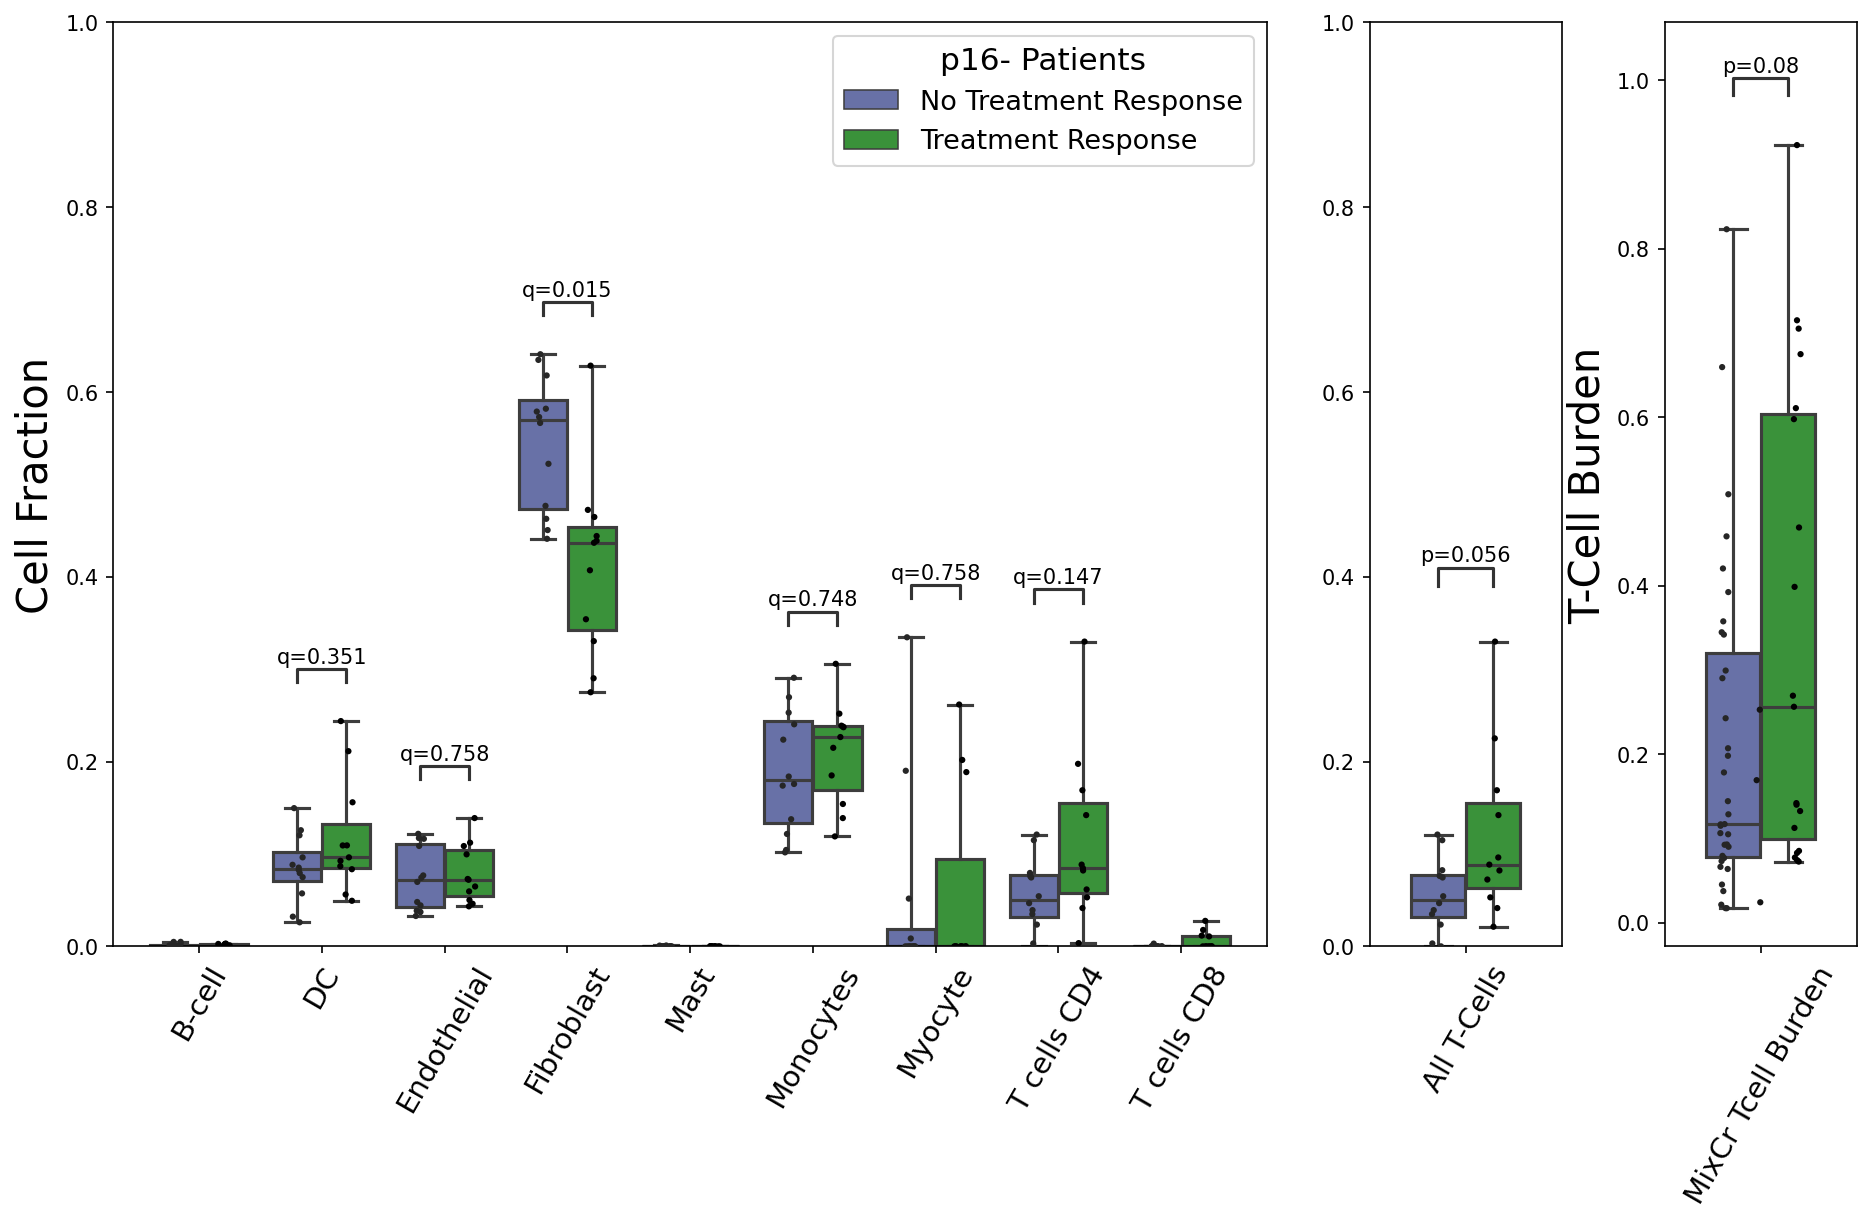

In [11]:
'''
plotting
'''

angle=60

fig = plt.figure(figsize=(15,8))

spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[6, 1, 1], wspace=0.2,
                         hspace=0.5, height_ratios=[1])

'''
ax0
'''
ax0 = fig.add_subplot(spec[0])

order=['No Response', 'Response']

sns.boxplot(x="cell_type_coarse",y="cell fraction", hue='treatment_response', hue_order=order, data=df, whis=1000, showfliers=False, ax=ax0, palette=mappings['clinical'])
sns.stripplot(x="cell_type_coarse",y="cell fraction", hue='treatment_response', hue_order=order, size=3, data=df, palette='dark:k', dodge=True, ax=ax0)

annot = Annotator(ax0, ind_tests, data=df, x='cell_type_coarse', y='cell fraction', hue='treatment_response', hue_order=order)
annots = res.loc[ct_test, 'annot'].to_list()
annot.configure().set_custom_annotations(annots).annotate();

plt.xticks(rotation = angle,fontsize=14);
plt.ylabel('Cell Fraction')
plt.xlabel('')
plt.ylim(0,1)

handles, labels = ax0.get_legend_handles_labels()

ax0.legend(handles[:2], ['No Treatment Response', 'Treatment Response'], title='p16- Patients', fontsize=13, title_fontsize=15)#, ncols=2)

'''
ax1
'''
ax1 = fig.add_subplot(spec[1], sharey=ax0)

sns.boxplot(x='cell_type', y='cell fraction', hue='treatment_response', data=df_t, hue_order=order, showfliers=False, whis=1000, ax=ax1, palette=mappings['clinical'])
sns.stripplot(x='cell_type', y='cell fraction', hue='treatment_response', data=df_t, hue_order=order, size=3, palette='dark:k', dodge=True, ax=ax1)
plt.xticks(rotation = angle,fontsize=14);


annot2 = Annotator(ax1, ind_tests2, data=df_t, x='cell_type', y='cell fraction', hue='treatment_response', hue_order=order)
annots = pd.Series(tcell_p_annot)
annot2.configure().set_custom_annotations(annots).annotate();


ax1.get_legend().remove()
ax1.set(ylabel='', xlabel='');

ax2 = fig.add_subplot(spec[2])

sns.boxplot(x="cell_type_coarse",y="cell fraction",hue="treatment_response", data=df_counts, whis=1000, hue_order=order, palette=mappings['clinical'], ax=ax2)
sns.stripplot(x="cell_type_coarse",y="cell fraction",hue="treatment_response", size=3, data=df_counts, palette='dark:k', dodge=True, ax=ax2)
plt.xticks(rotation = angle, fontsize=14);

annot3 = Annotator(ax2, ind_tests3, data=df_counts, x='cell_type_coarse', y='cell fraction', hue='treatment_response', hue_order=order)
annots = pd.Series(mixcr_p_annot)
annot3.configure().set_custom_annotations(annots).annotate();

ax2.get_legend().remove()
ax2.set(ylabel='T-Cell Burden', xlabel='');